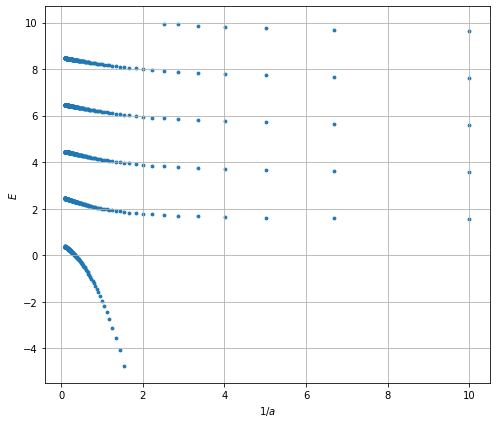

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.optimize import brentq

mp.mp.dps = 30  # numerical precision

def lhs(E):
    # use mpmath internally; E may be float
    E = mp.mpf(E)
    return mp.gamma(-E/2 + mp.mpf(3)/4) / mp.gamma(-E/2 + mp.mpf(1)/4)

# parameters for scanning
a_values = np.linspace(0.1, 10, 200)
inv_a_values = 1.0 / a_values
En_min, En_max = -5.0, 10.0
EnGrid = np.linspace(En_min, En_max, 4000)

# === compute analytical pole positions in the energy window ===
def compute_poles(En_min, En_max):
    poles_num = []  # numerator poles: E = 2m + 3/2 (1.5, 3.5, ...)
    poles_den = []  # denominator poles: E = 2n + 1/2 (0.5, 2.5, ...)
    # choose m,n range large enough to cover window
    m_min = int(np.floor((En_min - 1.5)/2.0)) - 1
    m_max = int(np.ceil((En_max - 1.5)/2.0)) + 1
    n_min = int(np.floor((En_min - 0.5)/2.0)) - 1
    n_max = int(np.ceil((En_max - 0.5)/2.0)) + 1

    for m in range(m_min, m_max+1):
        E = 2*m + 1.5
        if En_min <= E <= En_max:
            poles_num.append(E)
    for n in range(n_min, n_max+1):
        E = 2*n + 0.5
        if En_min <= E <= En_max:
            poles_den.append(E)
    return np.array(sorted(poles_num + poles_den))

poles = compute_poles(En_min, En_max)
# choose an exclusion radius (depends on grid spacing & desired safety)
exclusion_radius = 1e-2  # 0.01 energy units; increase if needed

# You can print poles to verify:
#print("Poles in range:", poles)

# storage for plotting
all_inv_a = []
all_E = []

for a, inva in zip(a_values, inv_a_values):
    rhs = inva
    # compute f on grid but mark as nan inside pole neighborhoods
    fGrid = np.empty_like(EnGrid)
    for i, E in enumerate(EnGrid):
        # if E is within exclusion_radius of a pole, mark as nan
        if np.any(np.abs(E - poles) < exclusion_radius):
            fGrid[i] = np.nan
            continue
        try:
            fGrid[i] = float(lhs(E) - rhs)
        except Exception:
            fGrid[i] = np.nan

    solutions = []
    # now bracket roots but skip intervals that intersect pole neighborhoods
    for i in range(len(EnGrid)-1):
        E1, E2 = EnGrid[i], EnGrid[i+1]
        # skip if either grid point is nan
        if not np.isfinite(fGrid[i]) or not np.isfinite(fGrid[i+1]):
            continue
        # also skip if the interval crosses any excluded pole neighborhood
        mid = 0.5*(E1 + E2)
        # if [E1,E2] intersects a neighborhood, skip
        if np.any((poles >= E1 - exclusion_radius) & (poles <= E2 + exclusion_radius)):
            continue
        f1, f2 = fGrid[i], fGrid[i+1]
        if f1 * f2 < 0:
            try:
                root = brentq(lambda x: float(lhs(x) - rhs), E1, E2, maxiter=200)
                # sanity: don't accept roots too close to a pole
                if np.any(np.abs(root - poles) < exclusion_radius):
                    continue
                solutions.append(root)
            except Exception:
                pass

    # deduplicate
    solutions = np.unique(np.round(solutions, 10))

    for E in solutions:
        all_inv_a.append(inva)
        all_E.append(E)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(all_inv_a, all_E, s=8)
plt.xlabel(r"$1/a$")
plt.ylabel(r"$E$")
plt.grid(True)
plt.tight_layout()
plt.show()

